<a href="https://colab.research.google.com/github/FKz11/Portfolio_Data_Science_2.0/blob/main/hand_gesture_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# hand_gesture_recognition

## Техническое задание:

### Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.

### Библиотеки:

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

# -- PART 1. BASELINE --

## Обучения классификатора

### Данные

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/leapGestRecog.zip'

In [4]:
num_data = sorted(os.listdir("./leapGestRecog"))
print(f'Num Data - {num_data}')
classes_data = sorted(os.listdir("./leapGestRecog/00"))
print(f'Data Classes - {classes_data}')

Num Data - ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']
Data Classes - ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


In [5]:
for data in os.listdir("./leapGestRecog"):
  print(f'############ {data} ############')
  for gesture in os.listdir(f"./leapGestRecog/{data}"):
    print(gesture, len(os.listdir(f"./leapGestRecog/00/{gesture}")))

############ 09 ############
07_ok 200
05_thumb 200
02_l 200
10_down 200
06_index 200
04_fist_moved 200
09_c 200
03_fist 200
01_palm 200
08_palm_moved 200
############ 08 ############
07_ok 200
05_thumb 200
02_l 200
10_down 200
06_index 200
04_fist_moved 200
09_c 200
03_fist 200
01_palm 200
08_palm_moved 200
############ 06 ############
07_ok 200
05_thumb 200
02_l 200
10_down 200
06_index 200
04_fist_moved 200
09_c 200
03_fist 200
01_palm 200
08_palm_moved 200
############ 01 ############
07_ok 200
05_thumb 200
02_l 200
10_down 200
06_index 200
04_fist_moved 200
09_c 200
03_fist 200
01_palm 200
08_palm_moved 200
############ 04 ############
07_ok 200
05_thumb 200
02_l 200
10_down 200
06_index 200
04_fist_moved 200
09_c 200
03_fist 200
01_palm 200
08_palm_moved 200
############ 02 ############
07_ok 200
05_thumb 200
02_l 200
10_down 200
06_index 200
04_fist_moved 200
09_c 200
03_fist 200
01_palm 200
08_palm_moved 200
############ 00 ############
07_ok 200
05_thumb 200
02_l 200
10_down 2

Видно, что у нас в каждом пакете данных, в каждом классе по 200 примеров, возьмём 160 для train и 40 для test(test_size = 0.2):

In [6]:
test_size = 0.2

train_data = []
train_labels = []
test_data = []
test_labels = []

for data in os.listdir("./leapGestRecog"):
  for gesture in os.listdir(f"./leapGestRecog/{data}"):
    imgs =  os.listdir(f"./leapGestRecog/{data}/{gesture}")
    trashold = int((1-test_size)*len(imgs))
    for img in imgs[:trashold]:
      train_data.append(f"./leapGestRecog/{data}/{gesture}/{img}")
      train_labels.append(int(gesture[:2]))
    for img in imgs[trashold:]:
      test_data.append(f"./leapGestRecog/{data}/{gesture}/{img}")
      test_labels.append(int(gesture[:2]))

In [7]:
print(len(train_data))
print(len(test_data))

16000
4000


In [8]:
train_data[160*2:160*2+5]

['./leapGestRecog/09/02_l/frame_09_02_0143.png',
 './leapGestRecog/09/02_l/frame_09_02_0075.png',
 './leapGestRecog/09/02_l/frame_09_02_0122.png',
 './leapGestRecog/09/02_l/frame_09_02_0033.png',
 './leapGestRecog/09/02_l/frame_09_02_0023.png']

In [9]:
train_labels[160*2:160*2+5]

[2, 2, 2, 2, 2]

### Пример

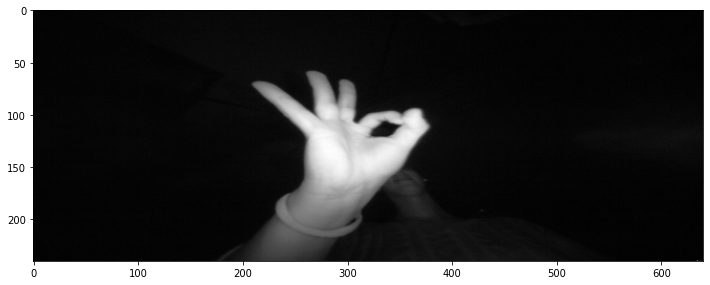

In [10]:
img = plt.imread(train_data[0])
plt.figure(figsize = (12,12))
plt.imshow(img, cmap='gray');

In [11]:
img.shape

(240, 640)

### Dataset

In [12]:
class MyDataset(Dataset):
    def __init__(self, data, labels, tfms):
      
      self.data = data
      self.labels = labels
      self.tfms = tfms

    def __getitem__(self, index):

      img = plt.imread(self.data[index])
      img = self.tfms(img)

      label = self.labels[index] - 1 # так как labels от 1 до 10

      return img, label

    def __len__(self):
      return len(self.labels)

In [13]:
SIZE = (128, 128)

In [14]:
train_tfms = tt.Compose([tt.ToTensor(),
                         tt.Resize(SIZE),
                         tt.RandomHorizontalFlip()])
test_tfms = tt.Compose([tt.ToTensor(),
                        tt.Resize(SIZE)])

In [15]:
train_dataset = MyDataset(train_data, train_labels, train_tfms)
test_dataset = MyDataset(test_data, test_labels, test_tfms)

### DataLoader

In [16]:
BATCH_SIZE = 16

In [17]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader= DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

In [18]:
def show_batch(loader):
    for images, labels in loader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:BATCH_SIZE], nrow=int(np.sqrt(BATCH_SIZE))).permute(1, 2, 0))
        break

torch.Size([1, 128, 128])


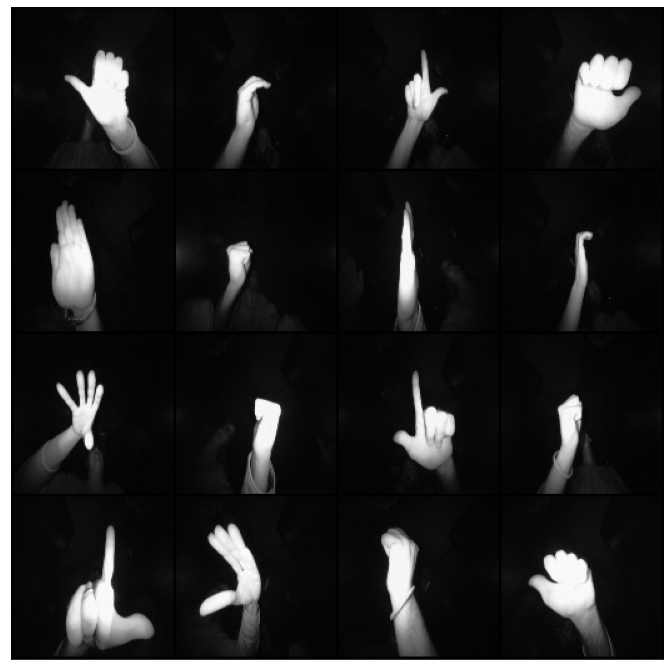

In [19]:
show_batch(train_loader)

### Модель 

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class MyNet(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_dim, dropout):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, hidden_dim)
        self.conv2 = conv_block(hidden_dim, hidden_dim, pool=True)
        self.res1 = nn.Sequential(conv_block(hidden_dim, hidden_dim), conv_block(hidden_dim, hidden_dim))
        
        self.conv3 = conv_block(hidden_dim, hidden_dim*2)
        self.conv4 = conv_block(hidden_dim*2, hidden_dim*2, pool=True)
        self.res2 = nn.Sequential(conv_block(hidden_dim*2, hidden_dim*2), conv_block(hidden_dim*2, hidden_dim*2))
        
        self.conv5 = conv_block(hidden_dim*2, hidden_dim*4)
        self.conv6 = conv_block(hidden_dim*4, hidden_dim*4, pool=True)
        self.res3 = nn.Sequential(conv_block(hidden_dim*4, hidden_dim*4), conv_block(hidden_dim*4, hidden_dim*4))

        self.drop = nn.Dropout(dropout)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(int(SIZE[0]/2**3)), 
                                        nn.Flatten(),
                                        nn.Linear(hidden_dim*4, num_classes))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop(out)
        
        out = self.classifier(out)
        return out

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
model = MyNet(1, len(np.unique(train_labels)), 128, 0.5).to(device)

In [23]:
model

MyNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [24]:
num_parameters = 0
for parameter in model.parameters():
  num_parameters += parameter.nelement()
num_parameters

10781322

### Обучение

In [25]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [26]:
%%time

epochs = 3

for epoch_num in range(epochs):
    train_loss = 0
    test_loss = 0
    train_acc = 0
    test_acc = 0
    
    model.train()
    for imgs, labels in tqdm(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        output = model(imgs)
                
        loss = criterion(output, labels)
        train_loss += loss.item()
                
        train_acc += (output.argmax(dim=1) == labels).sum().item() / len(labels)

        model.zero_grad()
        loss.backward()
        optimizer.step()
            
    model.eval()
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        output = model(imgs)

        loss = criterion(output, labels)
        test_loss += loss.item()
                    
        test_acc += (output.argmax(dim=1) == labels).sum().item() / len(labels)
            
    print(
        f'Epochs: {epoch_num + 1} | Train Loss: {train_loss / len(train_loader): .6f} \
        | Train Accuracy: {train_acc / len(train_loader): .6f} \
        | Test Loss: {test_loss / len(test_loader): .6f} \
        | Test Accuracy: {test_acc / len(test_loader): .6f}')

100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


Epochs: 1 | Train Loss:  1.890148         | Train Accuracy:  0.541438         | Test Loss:  0.520065         | Test Accuracy:  0.799000


100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


Epochs: 2 | Train Loss:  0.135719         | Train Accuracy:  0.957500         | Test Loss:  0.042854         | Test Accuracy:  0.993750


100%|██████████| 1000/1000 [02:58<00:00,  5.62it/s]


Epochs: 3 | Train Loss:  0.134728         | Train Accuracy:  0.961063         | Test Loss:  0.172446         | Test Accuracy:  0.924250
CPU times: user 9min 46s, sys: 7.85 s, total: 9min 54s
Wall time: 10min 13s


### Сохраним классификатор:

In [27]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/classification_model.pth')

### ------ checkpoint ------

### Загрузим классификатор:

In [28]:
classification_model = torch.load('/content/drive/MyDrive/Colab Notebooks/classification_model.pth')
classification_model.eval()

MyNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### Загрузим face detector

In [29]:
!pip install -qq facenet_pytorch

     |████████████████████████████████| 1.9 MB 35.2 MB/s 


In [30]:
from facenet_pytorch import MTCNN

In [31]:
mtcnn = MTCNN()

### Создадим каталог для сохранения лиц пользователей

In [32]:
os.mkdir('user faces')

### Вставим js скрипты для захвата камеры в colabotary

Источник: https://www.youtube.com/watch?v=YjWh7QvVH60

Библиотеки:

In [33]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

Скрипты:

In [34]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [35]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '800px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});

      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

Функция для детектирования лица

In [36]:
def face_detect(mtcnn, flip_img, bbox_array, face_box_color, face_landmarks_color):

    # get face region coordinates
    boxes, probs, landmarks = mtcnn.detect(flip_img, landmarks=True)
    # get face bounding box for overlay
    if boxes is not None:
      # Draw rectangle on frame
      for (a,b,c,d) in boxes.astype(int):
        bbox_array = cv2.rectangle(bbox_array,(a,b),(c,d),face_box_color, thickness=2)
      # Draw landmarks
      for face_landmarks in landmarks.astype(int):
        for landmark in face_landmarks:
          bbox_array = cv2.circle(bbox_array, tuple(landmark), 4, face_landmarks_color, -1)

    return boxes, bbox_array

Функция выводящая результаты работы модели

In [37]:
def print_output(bbox_array, output, classes_data, x_txt, y_txt, step):
  x_txt, y_txt = int(x_txt * bbox_array.shape[0]), int(y_txt * bbox_array.shape[1])
  step = int(step * bbox_array.shape[1])
  for i in range(len(output[0])):
    # Выводим score для каждого класса
    bbox_array = cv2.putText(bbox_array, f'{classes_data[i]}: {round(output[0][i].item(), 3)}', 
                              (x_txt, y_txt+step*i), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,255,0), 1, cv2.LINE_AA)
  # Выводим самый вероятный класс его вероятность
  bbox_array = cv2.putText(bbox_array, f'{classes_data[output.argmax().item()]}: {round(F.softmax(output, dim=1).max().item()*100, 3)}%', 
                            (x_txt, y_txt+step*len(output[0])+3*step), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)    
  return bbox_array

## Pipeline

In [38]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # face detect
    boxes, bbox_array = face_detect(mtcnn, img, bbox_array, (255,0,0), (0,0,255))

    # if detect
    if boxes is not None:
      # save face
      for (a,b,c,d) in boxes.astype(int):
        cv2.imwrite(f'./user faces/{time.ctime()}.jpg', img[int(b):int(d),int(a):int(c)])
      # resize image
      resize = cv2.resize(img, SIZE)
      # grayscale image
      bgr2gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
      # image to tensor
      tensor = torch.FloatTensor(bgr2gray) / 255
      # tensor to device
      tensor = tensor[None,None,:,:].to(device)

      # predict classification_model
      classification_model.eval()
      output = classification_model(tensor)

      # print output classification_model
      bbox_array = print_output(bbox_array, output, classes_data, x_txt=0.05, y_txt=0.05, step=0.04)    
      
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

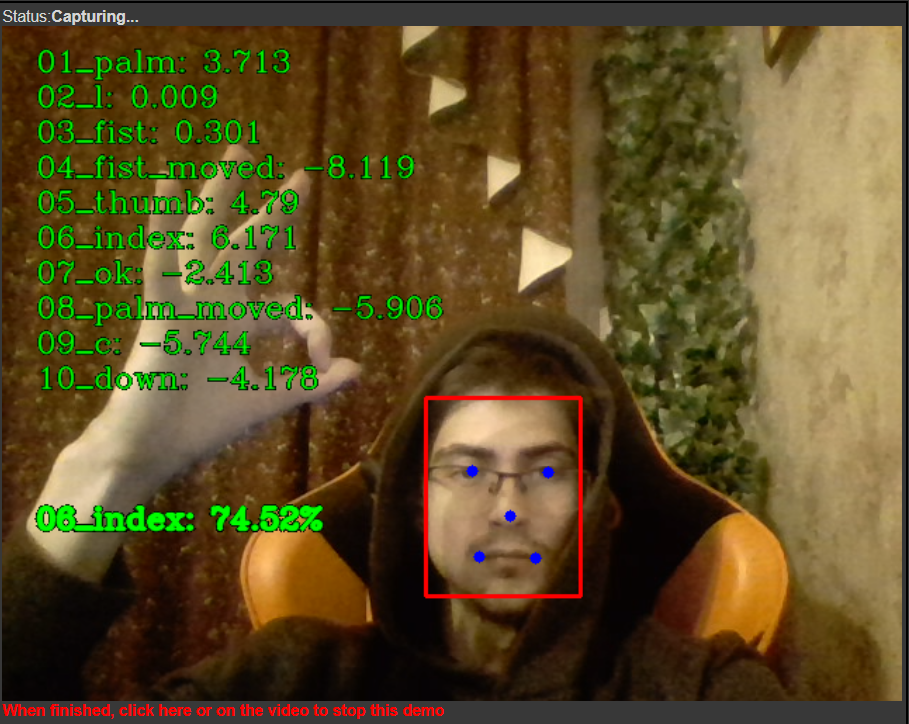

Видно, что модель не справляется, так как обучающие + тестовые данные недостаточно генерализированны. Моё видео с вебкамеры, даже переведенное в серые тона, всё равно слишком отчиается от тех данных, на которых тренировалась и проверялась классификационная модель.

# -- PART 2. ADVANCED SOLUTION --

### Переосмыслим задачу. 

Воспользуемся mediapipe, чтобы сначала детектировать ключевые точки руки(landmarks), а потом уже её классифицировать.

In [39]:
!pip install -qq mediapipe

     |████████████████████████████████| 32.9 MB 1.4 MB/s 


In [40]:
import mediapipe as mp

Посмотрим сколько всего у нас данных

In [41]:
count_labels = {}
for i in range(1,11):
  count_labels[str(i)] = (train_labels+test_labels).count(i)
count_labels

{'1': 2000,
 '10': 2000,
 '2': 2000,
 '3': 2000,
 '4': 2000,
 '5': 2000,
 '6': 2000,
 '7': 2000,
 '8': 2000,
 '9': 2000}

Теперь попробуем получить ключевые точки для наших данных. Понятно, что детектор не сможет дать точки для каждой картинки

In [98]:
%%time
hands = mp.solutions.hands.Hands(
        static_image_mode=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        max_num_hands=1) # 1 так как на каждой фотографии только один жест
# обьединим данные
data = train_data+test_data 
labels = train_labels+test_labels
data_landmarks = []
labels_landmarks = []
for i in tqdm(range(len(labels))):
  image = cv2.imread(data[i])
  results = hands.process(image)
  if results.multi_hand_landmarks:
    landmarks = []
    for landmark in results.multi_hand_landmarks[0].landmark:
      landmarks.append([landmark.x, landmark.y])
    # !!! Нормализуем данные от 0 до 1 (min-max normalisation) !!!
    landmarks = np.array(landmarks)
    landmarks[:,0] -= min(landmarks[:,0])
    landmarks[:,1] -= min(landmarks[:,1])
    landmarks[:,0] /= max(landmarks[:,0])
    landmarks[:,1] /= max(landmarks[:,1])
    data_landmarks.append(landmarks)   
    labels_landmarks.append(labels[i])

100%|██████████| 20000/20000 [10:44<00:00, 31.03it/s]

CPU times: user 10min 43s, sys: 7.94 s, total: 10min 51s
Wall time: 10min 44s


Посмторим для скольких примером детектор смог получить точки

In [99]:
count_labels_landmarks = {}
for i in range(1,11):
  count_labels_landmarks[classes_data[i-1]] = labels_landmarks.count(i)
count_labels_landmarks

{'01_palm': 1709,
 '02_l': 1046,
 '03_fist': 444,
 '04_fist_moved': 162,
 '05_thumb': 847,
 '06_index': 596,
 '07_ok': 1657,
 '08_palm_moved': 199,
 '09_c': 455,
 '10_down': 1432}

Найдём дизбаланс классов относительно наименьшего, для учёта его при обучении

In [100]:
class_count = np.array(list(count_labels_landmarks.values())).astype(float)
class_weights = max(class_count)
class_weights /= class_count
class_weights

array([ 1.        ,  1.63384321,  3.8490991 , 10.54938272,  2.01770956,
        2.86744966,  1.03138202,  8.5879397 ,  3.75604396,  1.19343575])

### train/test split
Так, чтобы в обучающей и тествовой выборке были одинаковые соотношения классов

In [101]:
test_size = 0.2

train_data_landmarks = []
train_labels_landmarks = []
test_data_landmarks = []
test_labels_landmarks = []

data_landmarks = np.array(data_landmarks)
labels_landmarks = np.array(labels_landmarks)

for i in range(1,11):
  mask = (labels_landmarks==i)
  trashold = int((1-test_size)*sum(mask))
  train_data_landmarks.extend(data_landmarks[mask][:trashold])
  train_labels_landmarks.extend([i]*trashold)
  test_data_landmarks.extend(data_landmarks[mask][trashold:])
  test_labels_landmarks.extend([i]*(sum(mask)-trashold))

### Dataset

In [102]:
class MyDataset(Dataset):
    def __init__(self, data_landmarks, labels_landmarks):
      
      self.data_landmarks = data_landmarks
      self.labels_landmarks = labels_landmarks

    def __getitem__(self, index):
      data = torch.FloatTensor(self.data_landmarks[index])
      label = self.labels_landmarks[index] - 1

      return data, label

    def __len__(self):
      return len(self.labels_landmarks)

In [103]:
train_dataset = MyDataset(train_data_landmarks, train_labels_landmarks)
test_dataset = MyDataset(test_data_landmarks, test_labels_landmarks)

### DataLoader

In [104]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

drop_last=True, так как при train, BatchNorm всегда ожидает в пакете больше одного значения для расчёта статистик, но я не могу гарантировать, что в последнем будет хотя бы больше одного, так как теперь размер тренировочных данных может быть нечётным

### Модель

Обычный трёхслойный классификатор, его вполне достаточно для решения задачи с landmarks

In [105]:
class MyNet(nn.Module):
    def __init__(self, in_channel, length, hidden_dim, num_classes, dropout):
        super().__init__()
        self.linear_1 = nn.Linear(in_channel*length, hidden_dim)
        self.bn_1 = nn.BatchNorm1d(hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn_2 = nn.BatchNorm1d(hidden_dim // 2)
        self.linear_3 = nn.Linear(hidden_dim // 2, num_classes)

        self.relu = nn.ReLU()
        self.dp = nn.Dropout(dropout)
        
    def forward(self, x):  
        x = torch.flatten(x, start_dim=1)

        output = self.linear_1(x)
        output = self.bn_1(output)
        output = self.relu(output)
        output = self.dp(output)

        output = self.linear_2(output)
        output = self.bn_2(output)
        output = self.relu(output)
        output = self.dp(output)
        
        output = self.linear_3(output)
        return output

In [106]:
model = MyNet(data_landmarks.shape[2], data_landmarks.shape[1], 512, len(classes_data), 0.2)
model = model.to(device)
model.train()

MyNet(
  (linear_1): Linear(in_features=42, out_features=512, bias=True)
  (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (bn_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dp): Dropout(p=0.2, inplace=False)
)

In [107]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device), reduction='mean')

Так как классы теперь несбалансированны, то accuracy уже не является хорошей метрикой, поэтому будем использовать f1_score

In [108]:
from sklearn.metrics import f1_score

### Обучение

In [109]:
%%time

epochs = 20

for epoch_num in range(epochs):
    train_loss = 0
    test_loss = 0
    train_acc = 0
    test_acc = 0
    test_f1 = 0
    
    model.train()
    for landmarks, labels in tqdm(train_loader):
        landmarks = landmarks.to(device)
        labels = labels.to(device)

        output = model(landmarks)
                
        loss = criterion(output, labels)
        train_loss += loss.item()
                
        train_acc += (output.argmax(dim=1) == labels).sum().item() / len(labels)

        model.zero_grad()
        loss.backward()
        optimizer.step()
            
    model.eval()
    for landmarks, labels in test_loader:
        landmarks = landmarks.to(device)
        labels = labels.to(device)

        output = model(landmarks)

        loss = criterion(output, labels)
        test_loss += loss.item()
                    
        test_acc += (output.argmax(dim=1) == labels).sum().item() / len(labels)

        test_f1 += f1_score(labels.detach().cpu().numpy().astype(int), (output.detach().cpu().numpy().argmax(1)).astype(int), average='weighted')
            
    print(
        f'Epochs: {epoch_num + 1} | Train Loss: {train_loss / len(train_loader): .6f} \
        | Train Accuracy: {train_acc / len(train_loader): .6f} \
        | Test Loss: {test_loss / len(test_loader): .6f} \
        | Test Accuracy: {test_acc / len(test_loader): .6f} \
        | Test_f1: {test_f1 / len(test_loader): .6f}')

100%|██████████| 427/427 [00:01<00:00, 329.34it/s]


Epochs: 1 | Train Loss:  0.369934         | Train Accuracy:  0.899151         | Test Loss:  0.187701         | Test Accuracy:  0.931713         | Test_f1:  0.937652


100%|██████████| 427/427 [00:01<00:00, 331.43it/s]


Epochs: 2 | Train Loss:  0.171776         | Train Accuracy:  0.947892         | Test Loss:  0.079830         | Test Accuracy:  0.978009         | Test_f1:  0.980572


100%|██████████| 427/427 [00:01<00:00, 330.68it/s]


Epochs: 3 | Train Loss:  0.122079         | Train Accuracy:  0.960480         | Test Loss:  0.073198         | Test Accuracy:  0.978588         | Test_f1:  0.980459


100%|██████████| 427/427 [00:01<00:00, 337.06it/s]


Epochs: 4 | Train Loss:  0.104093         | Train Accuracy:  0.964871         | Test Loss:  0.061921         | Test Accuracy:  0.984375         | Test_f1:  0.984781


100%|██████████| 427/427 [00:01<00:00, 335.28it/s]


Epochs: 5 | Train Loss:  0.079360         | Train Accuracy:  0.973361         | Test Loss:  0.082946         | Test Accuracy:  0.975116         | Test_f1:  0.977548


100%|██████████| 427/427 [00:01<00:00, 339.24it/s]


Epochs: 6 | Train Loss:  0.081488         | Train Accuracy:  0.973800         | Test Loss:  0.108974         | Test Accuracy:  0.957755         | Test_f1:  0.964820


100%|██████████| 427/427 [00:01<00:00, 329.73it/s]


Epochs: 7 | Train Loss:  0.078500         | Train Accuracy:  0.972629         | Test Loss:  0.058164         | Test Accuracy:  0.983218         | Test_f1:  0.983141


100%|██████████| 427/427 [00:01<00:00, 329.75it/s]


Epochs: 8 | Train Loss:  0.073727         | Train Accuracy:  0.975995         | Test Loss:  0.118070         | Test Accuracy:  0.973380         | Test_f1:  0.969312


100%|██████████| 427/427 [00:01<00:00, 334.70it/s]


Epochs: 9 | Train Loss:  0.063940         | Train Accuracy:  0.976581         | Test Loss:  0.072573         | Test Accuracy:  0.984954         | Test_f1:  0.985709


100%|██████████| 427/427 [00:01<00:00, 288.19it/s]


Epochs: 10 | Train Loss:  0.063945         | Train Accuracy:  0.975703         | Test Loss:  0.168648         | Test Accuracy:  0.960648         | Test_f1:  0.957924


100%|██████████| 427/427 [00:01<00:00, 252.26it/s]


Epochs: 11 | Train Loss:  0.056188         | Train Accuracy:  0.982143         | Test Loss:  0.112196         | Test Accuracy:  0.978588         | Test_f1:  0.976485


100%|██████████| 427/427 [00:01<00:00, 326.41it/s]


Epochs: 12 | Train Loss:  0.047334         | Train Accuracy:  0.984485         | Test Loss:  0.044999         | Test Accuracy:  0.990162         | Test_f1:  0.991003


100%|██████████| 427/427 [00:01<00:00, 342.42it/s]


Epochs: 13 | Train Loss:  0.059184         | Train Accuracy:  0.976434         | Test Loss:  0.062597         | Test Accuracy:  0.984954         | Test_f1:  0.986189


100%|██████████| 427/427 [00:01<00:00, 331.66it/s]


Epochs: 14 | Train Loss:  0.048635         | Train Accuracy:  0.983314         | Test Loss:  0.047213         | Test Accuracy:  0.987847         | Test_f1:  0.988509


100%|██████████| 427/427 [00:01<00:00, 333.64it/s]


Epochs: 15 | Train Loss:  0.051542         | Train Accuracy:  0.981118         | Test Loss:  0.095903         | Test Accuracy:  0.978588         | Test_f1:  0.977948


100%|██████████| 427/427 [00:01<00:00, 339.05it/s]


Epochs: 16 | Train Loss:  0.035680         | Train Accuracy:  0.986827         | Test Loss:  0.104956         | Test Accuracy:  0.976273         | Test_f1:  0.973665


100%|██████████| 427/427 [00:01<00:00, 336.09it/s]


Epochs: 17 | Train Loss:  0.053447         | Train Accuracy:  0.983314         | Test Loss:  0.411652         | Test Accuracy:  0.946181         | Test_f1:  0.946415


100%|██████████| 427/427 [00:01<00:00, 342.53it/s]


Epochs: 18 | Train Loss:  0.042571         | Train Accuracy:  0.983021         | Test Loss:  0.193779         | Test Accuracy:  0.968171         | Test_f1:  0.963654


100%|██████████| 427/427 [00:01<00:00, 337.59it/s]


Epochs: 19 | Train Loss:  0.042596         | Train Accuracy:  0.983899         | Test Loss:  0.447901         | Test Accuracy:  0.965856         | Test_f1:  0.960874


100%|██████████| 427/427 [00:01<00:00, 343.20it/s]


Epochs: 20 | Train Loss:  0.049918         | Train Accuracy:  0.981850         | Test Loss:  0.123145         | Test Accuracy:  0.976273         | Test_f1:  0.973855
CPU times: user 29.4 s, sys: 592 ms, total: 29.9 s
Wall time: 30.2 s


### Сохраним классификатор:

In [110]:
torch.save(model, '/content/drive/MyDrive/Colab Notebooks/classification_model_landmarks.pth')

### ------ checkpoint ------

### Загрузим классификатор:

In [111]:
classification_model_landmarks = torch.load('/content/drive/MyDrive/Colab Notebooks/classification_model_landmarks.pth')
classification_model_landmarks.eval()

MyNet(
  (linear_1): Linear(in_features=42, out_features=512, bias=True)
  (bn_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (bn_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dp): Dropout(p=0.2, inplace=False)
)

Функция детектирования руки

In [112]:
def hand_landmarks_detect(image, hands, bbox_array, padding, hand_box_color):
    
    bbox_array_copy = bbox_array.copy()
    hand_landmarks = None
    handedness_index = None
    
    # Perform the Hands Landmarks Detection.
    results = hands.process(image)
    
    # Check if landmarks are found.
    if results.multi_hand_landmarks:
        
        hand_landmarks = []
        # Iterate over the found hands.
        for multi_hand_landmarks in results.multi_hand_landmarks:
            
           # Draw the hand landmarks on the copy of the input image.
           mp.solutions.drawing_utils.draw_landmarks(image = bbox_array_copy, landmark_list = multi_hand_landmarks,
                                  connections = mp.solutions.hands.HAND_CONNECTIONS) 
           
           # Собираем landmarks
           landmarks = []
           for landmark in multi_hand_landmarks.landmark:
              landmarks.append([landmark.x, landmark.y])
           landmarks = np.array(landmarks)

           # Границы bounding box
           x1, y1 = min(landmarks[:,0])*image.shape[1], min(landmarks[:,1])*image.shape[0]
           x2, y2 = max(landmarks[:,0])*image.shape[1], max(landmarks[:,1])*image.shape[0]
           # Добавляем padding относительно размеров bounding box
           x1, y1 = int(x1-(x2-x1)*padding), int(y1-(y2-y1)*padding)
           x2, y2 = int(x2+(x2-x1)*padding), int(y2+(y2-y1)*padding)
           # Если с padding box вылезает за изображение, то пускай границей box будет граница изображения
           x1, y1 = x1 if x1 > 0 else 0, y1 if y1 > 0 else 0
           x2, y2 = x2 if x2 < image.shape[1] else image.shape[1], y2 if y2 < image.shape[0] else image.shape[0]
           # Отрисовываем box
           bbox_array_copy = cv2.rectangle(bbox_array_copy,(x1, y1),(x2, y2),hand_box_color,thickness=2)

           # !!! Нормализуем данные от 0 до 1 (min-max normalisation) !!!
           landmarks[:,0] -= min(landmarks[:,0])
           landmarks[:,1] -= min(landmarks[:,1])
           landmarks[:,0] /= max(landmarks[:,0])
           landmarks[:,1] /= max(landmarks[:,1])
           hand_landmarks.append(landmarks)

        # Ориентация руки
        handedness_index = []
        for handedness in results.multi_handedness:
          handedness_index.append(handedness.classification[0].index)
        handedness_index = np.array(handedness_index)

        # ??? По какой-то причине, во время разработки этого проекта, mediapipe определяет руки с точность наоборот, 
        # поэтому временная(надеюсь) строчка, которая делает reverse данных ???
        handedness_index = (handedness_index-1)*(-1)

        # !!! Если рука левая, то отзеркаливаем landmarks путём: 1-x, так как в обучающих данных жесты показывались только правой рукой !!!
        hand_landmarks = np.array(hand_landmarks)
        for i in range(len(handedness_index)):
          if not handedness_index[i]:
            hand_landmarks[i,:,0] = 1 - hand_landmarks[i,:,0]
        
    # Return the output bbox_array and results of hands landmarks detection.
    return bbox_array_copy, hand_landmarks, handedness_index

Функция выводящая результаты работы модели

In [113]:
def print_output(bbox_array, output, classes_data, handedness_index, x_padding, y_padding, step, output_color):
  y_txt = int(y_padding * bbox_array.shape[0])
  step = int(step * bbox_array.shape[0])
  # Перебираем найденные руки
  for i in range(len(handedness_index)):
    # Если рука левая, ровняем по левому краю, если правая, по правому
    x_txt = int((1-x_padding-(1-2*x_padding)*handedness_index[i]) * bbox_array.shape[1])

    # Выводим score для каждого класса
    for j in range(len(classes_data)):
      text = f'{classes_data[j]}: {round(output[i][j].item(), 3)}'
      (width, height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_COMPLEX, 0.7, 1)
      bbox_array = cv2.putText(bbox_array, text, (x_txt-width+width*handedness_index[i], y_txt+height+(height+step)*j), 
                               cv2.FONT_HERSHEY_COMPLEX, 0.7, output_color, 1, cv2.LINE_AA)

    # Выводим самый вероятный класс его вероятность
    text = f'{classes_data[output[i].argmax().item()]}: {round(F.softmax(output[i], dim=0).max().item()*100, 3)}%'
    (width, height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_COMPLEX, 0.7, 2)
    bbox_array = cv2.putText(bbox_array, text, (x_txt-width+width*handedness_index[i], y_txt+height+(height+step)*len(classes_data)+3*step), 
                             cv2.FONT_HERSHEY_COMPLEX, 0.7, output_color, 2, cv2.LINE_AA)    

    # Выводим ориентацию руки
    text = 'Right' if handedness_index[i] else 'Left'
    (width, height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_COMPLEX, 0.7, 2)
    bbox_array = cv2.putText(bbox_array, text, (x_txt-width+width*handedness_index[i], y_txt+2*height+(height+step)*len(classes_data)+6*step), 
                             cv2.FONT_HERSHEY_COMPLEX, 0.7, output_color, 2, cv2.LINE_AA) 
  return bbox_array

Определяем hands

In [114]:
hands = mp.solutions.hands.Hands(
        static_image_mode=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        max_num_hands=2) # Будем анализировать сразу 2 руки

## Pipeline

In [115]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
# bbox_array_size
bbox_array_size = [480,640,4]

# Задаём какие слова будут печататься на определенный жест
palm = 'YOU'
l = 'LOVE'
fist = 'VALYA'
fist_moved = 'MUCH'
thumb = 'I'
index = ''
ok = None
palm_moved = ''
c = 'VERY'
down = ''

gestures = [palm, l, fist, fist_moved, thumb, index, ok, palm_moved, c, down]

# Жест после которого сообщение стерается
delete_index = gestures.index(None)

# Порог доверия для жеста
trashold = 0.95
        
# Задержка между словами
delay = 3 

# Это параметры для выводимого сообщения
step_message = 0.02
x_start_message, y_start_message = 0.4, 0.01
x_end_message = 1
step = int(step_message * bbox_array_size[0])
x_start = int(x_start_message * bbox_array_size[1])
y_start = int(y_start_message * bbox_array_size[0])
x_end = int(x_end_message * bbox_array_size[1])
messages = ['']
i_line_message = 0
width_line_message = 0
last_time = time.time()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros(bbox_array_size, dtype=np.uint8)

    # face detect
    boxes, bbox_array = face_detect(mtcnn, img, bbox_array, (255,0,0), (0,0,255))

    if boxes is not None:
      
      # landmarks detect
      bbox_array[:,:,:3], hand_landmarks, handedness_index = hand_landmarks_detect(img, hands, bbox_array[:,:,:3], 0.1, (255,0,0))

      if hand_landmarks is not None:
        # landmarks to tensor
        tensor = torch.FloatTensor(hand_landmarks).to(device)

        # predict classification_model_landmarks
        classification_model_landmarks.eval()
        output = classification_model_landmarks(tensor) 

        # print output classification_model_landmarks
        bbox_array = print_output(bbox_array, output, classes_data, handedness_index, 0.01, 0.01, 0.02, (0,255,0))  

        # Сначала вводится жест левой руки
        if len(handedness_index) == 2:
          if handedness_index[0] == 1 and handedness_index[1] == 0:
            torch.flip(output, dims=(0,))

        # Если прошло delay времени, то можно реагировать на новый жест
        if time.time() - last_time > delay:
          for out in output:
            max_score = F.softmax(out, dim=0).max().item()
            # Если max_score  > trashold, то происходит действие с сообщением
            if max_score  > trashold:
              max_name = out.argmax().item()
              # Если delete_index, то удаляем сообщение и всё обнуляем
              if max_name == delete_index:
                messages = ['']
                i_line_message = 0
                width_line_message = 0
              else:
                # save face только когда пользователь вводит слово
                for (a,b,c,d) in boxes.astype(int):
                  cv2.imwrite(f'./user faces/{time.ctime()}.jpg', img[b:d,a:c])
                # Ввод слова
                word = ' ' + gestures[max_name]
                (width, height), baseline = cv2.getTextSize(word, cv2.FONT_HERSHEY_COMPLEX, 0.7, 2)
                # Здесь если длина строки сообщения превышает допустимую, то мы переходим на другую строку
                if width_line_message + width > x_end - x_start:
                  i_line_message += 1
                  messages.append('')
                  width_line_message = 0
                messages[i_line_message] += word
                width_line_message += width
          last_time = time.time()

    # Пишем сообщение, даже если не показываем новые жесты
    for i in range(i_line_message+1):
      (width, height), baseline = cv2.getTextSize(messages[i], cv2.FONT_HERSHEY_COMPLEX, 0.7, 2)
      bbox_array = cv2.putText(bbox_array, messages[i], (x_start, y_start+height+(height+step)*i), 
                             cv2.FONT_HERSHEY_COMPLEX, 0.7, (215,125,49), 2, cv2.LINE_AA)  

      
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

Теперь соберём всё в функцию и вытащим параметры

In [117]:
def go_pipeline(mtcnn, classification_model_landmarks, hands, palm='YOU', l='LOVE', fist='VALYA', fist_moved='MUCH', thumb='I', 
                index='', ok=None, palm_moved='', c='VERY', down='', trashold=0.95, delay=3, step_message=0.02, x_start_message=0.4, 
                y_start_message=0.01, x_end_message=1, padding_landmarks_detect=0.1, x_padding_output=0.01, y_padding_output=0.01, 
                step_output=0.02, face_box_color=(255,0,0), face_landmarks_color=(0,0,255), hand_box_color=(255,0,0), 
                output_color=(0,255,0), message_color=(215,125,49)):
  # start streaming video from webcam
  video_stream()
  # label for video
  label_html = 'Capturing...'
  # initialze bounding box to empty
  bbox = ''
  count = 0 
  # bbox_array_size
  bbox_array_size = [480,640,4]

  # Задаём какие слова будут печататься на определенный жест
  gestures = [palm, l, fist, fist_moved, thumb, index, ok, palm_moved, c, down]

  # Жест после которого сообщение стерается
  delete_index = gestures.index(None)

  # Это параметры для выводимого сообщения
  step = int(step_message * bbox_array_size[0])
  x_start = int(x_start_message * bbox_array_size[1])
  y_start = int(y_start_message * bbox_array_size[0])
  x_end = int(x_end_message * bbox_array_size[1])
  messages = ['']
  i_line_message = 0
  width_line_message = 0
  last_time = time.time()

  while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros(bbox_array_size, dtype=np.uint8)

    # face detect
    boxes, bbox_array = face_detect(mtcnn, img, bbox_array, face_box_color, face_landmarks_color)

    if boxes is not None:
      
      # landmarks detect
      bbox_array[:,:,:3], hand_landmarks, handedness_index = hand_landmarks_detect(img, hands, bbox_array[:,:,:3], padding_landmarks_detect, hand_box_color)

      if hand_landmarks is not None:
        # landmarks to tensor
        tensor = torch.FloatTensor(hand_landmarks).to(device)

        # predict classification_model_landmarks
        classification_model_landmarks.eval()
        output = classification_model_landmarks(tensor) 

        # print output classification_model_landmarks
        bbox_array = print_output(bbox_array, output, classes_data, handedness_index, x_padding_output, y_padding_output, step_output, output_color)  

        # Сначала вводится жест левой руки
        if len(handedness_index) == 2:
          if handedness_index[0] == 1 and handedness_index[1] == 0:
            torch.flip(output, dims=(0,))

        # Если прошло delay времени, то можно реагировать на новый жест
        if time.time() - last_time > delay:
          for out in output:
            max_score = F.softmax(out, dim=0).max().item()
            # Если max_score  > trashold, то происходит действие с сообщением
            if max_score  > trashold:
              max_name = out.argmax().item()
              # Если delete_index, то удаляем сообщение и всё обнуляем
              if max_name == delete_index:
                messages = ['']
                i_line_message = 0
                width_line_message = 0
              else:
                # save face только когда пользователь вводит слово
                for (a,b,c,d) in boxes.astype(int):
                  cv2.imwrite(f'./user faces/{time.ctime()}.jpg', img[b:d,a:c])
                # Ввод слова
                word = ' ' + gestures[max_name]
                (width, height), baseline = cv2.getTextSize(word, cv2.FONT_HERSHEY_COMPLEX, 0.7, 2)
                # Здесь если длина строки сообщения превышает допустимую, то мы переходим на другую строку
                if width_line_message + width > x_end - x_start:
                  i_line_message += 1
                  messages.append('')
                  width_line_message = 0
                messages[i_line_message] += word
                width_line_message += width
          last_time = time.time()

    # Пишем сообщение, даже если не показываем новые жесты
    for i in range(i_line_message+1):
      (width, height), baseline = cv2.getTextSize(messages[i], cv2.FONT_HERSHEY_COMPLEX, 0.7, 2)
      bbox_array = cv2.putText(bbox_array, messages[i], (x_start, y_start+height+(height+step)*i), 
                             cv2.FONT_HERSHEY_COMPLEX, 0.7, message_color, 2, cv2.LINE_AA)  

      
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

# Final result

In [123]:
go_pipeline(mtcnn, 
            classification_model_landmarks, 
            hands,
            palm='YOU', 
            l='LOVE', 
            fist='VALYA', 
            fist_moved='MUCH', 
            thumb='I', 
            index='', 
            ok=None, 
            palm_moved='', 
            c='VERY', 
            down='', 
            trashold=0.95, 
            delay=3, 
            step_message=0.02, 
            x_start_message=0.4, 
            y_start_message=0.01, 
            x_end_message=1, 
            padding_landmarks_detect=0.1, 
            x_padding_output=0.01, 
            y_padding_output=0.01, 
            step_output=0.02, 
            face_box_color=(255,0,0), 
            face_landmarks_color=(0,0,255), 
            hand_box_color=(255,0,0), 
            output_color=(0,255,0), 
            message_color=(215,125,49))

<IPython.core.display.Javascript object>

*** ok -> fist -> thumb -> l -> palm -> c -> fist_moved -> ok ***

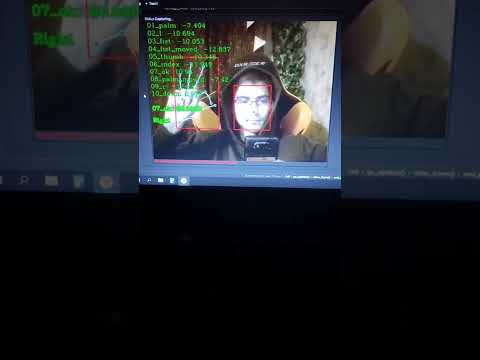

In [128]:
from IPython.display import YouTubeVideo

YouTubeVideo('vlZpr0GmdDM', width=500, height=900)

### Ссылка на видео с результатом работы:

### https://youtube.com/shorts/vlZpr0GmdDM

### Последнее сохранённое user face

In [135]:
from google.colab.patches import cv2_imshow

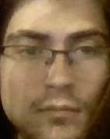

In [136]:
cv2_imshow(cv2.imread(f'./user faces/{os.listdir("./user faces")[-1]}'))

# Вывод:

При решении baseline задачи, я столкнулся с тем, что тренировочные и тестовые данные недостаточно генерализированы, поэтому на реальных изображениях с камеры вообще ничего не получалось. 

Поэтому я решил сначала детектировать руку, приводить картинку к контрастному виду и уже потом классифицировать, но я нашёл единственное open source решение: mediapipe, которое оказалось настолько мощным, что даже выдаёт ключевые точки руки(landmarks) и находит ориентацию руки(left/right). 

Я сразу же применил это в своём проекте, прогнав этот детектор через всю выборку и обучив новую простую трёхслойную модель на landmarks. Как и ожидалось, результаты просто отличные.

Так же я добавил незаурядное графическое оформление. 

В перспективе можно научить модель распознавать реальный язык жестов, где каждый жест - это отдельная буква, поставить меньше задержку и писать по буквам предложения. Так как это сделано в colab, то это даже можно запустить с телефона, с браузера, и использовать как переводчик языка жестов в real time. 

Я очень доволен своим результатом, он получился очень наглядным.